# WiSARD_Numba

I divided the task into 5 main modules: WiSARD Network, training (with bleaching), testing (with bleaching), preprocessing and numba implementation.

 I build the WiSARD network I.e discriminator for each class and the RAM table inside the classes. This random pixel selection of picture for each discriminator is fixed in this module (for RAM) and that is fixed for training and testing.

We use a weightless neural network as they do not require time to spend forward-backward  recursive  optimization  process  of  neurons  weights.   It  is  made  up  of RAM as nodes, in weightless neural models training at each new sample is just anincremental and one-way update process of neuron memories across network layer[6].  This makes them very fast.  This weightless neural network is called WiSARD and is introduced by Aleksander et al [7].

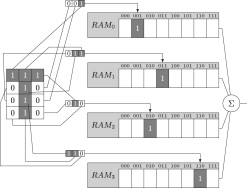

In [1]:
from IPython.display import Image
Image("wisard_n.jpg")

             Figure 1

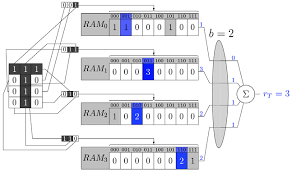

In [41]:
from IPython.display import Image
Image("wisard_bleaching.png")

             Figure 2

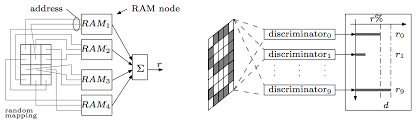

In [39]:
from IPython.display import Image
Image("wisard_conf.png")

Once we get the desired accuracy we can implement implement numba in the code to make it faster

               Figure 3

 I came to know that we cannot use numba for dictionaries and list (cannot pass it through kernel). Without that it was not possible to parallelize it on GPU. I did numba’s simple CPU JIT (just in time) implementation to lift the loops but it was taking more time then the implementation without JIT.

# Numba

Numba is a just-in-time Python function compiler that exposes a simple interface for accelerating numerically-focused Python functions. Numba is a very attractive option for Python programmers wishing to GPU accelerate their applications without needing to write C/C++ code, especially for developers already performing computationally heavy operations on NumPy arrays. Numba can be used to accelerate Python functions for the CPU, as well as for NVIDIA GPUs. The focus of this course is the fundamental techniques needed to GPU-accelerate Python applications using Numba.

Numba flowchart:

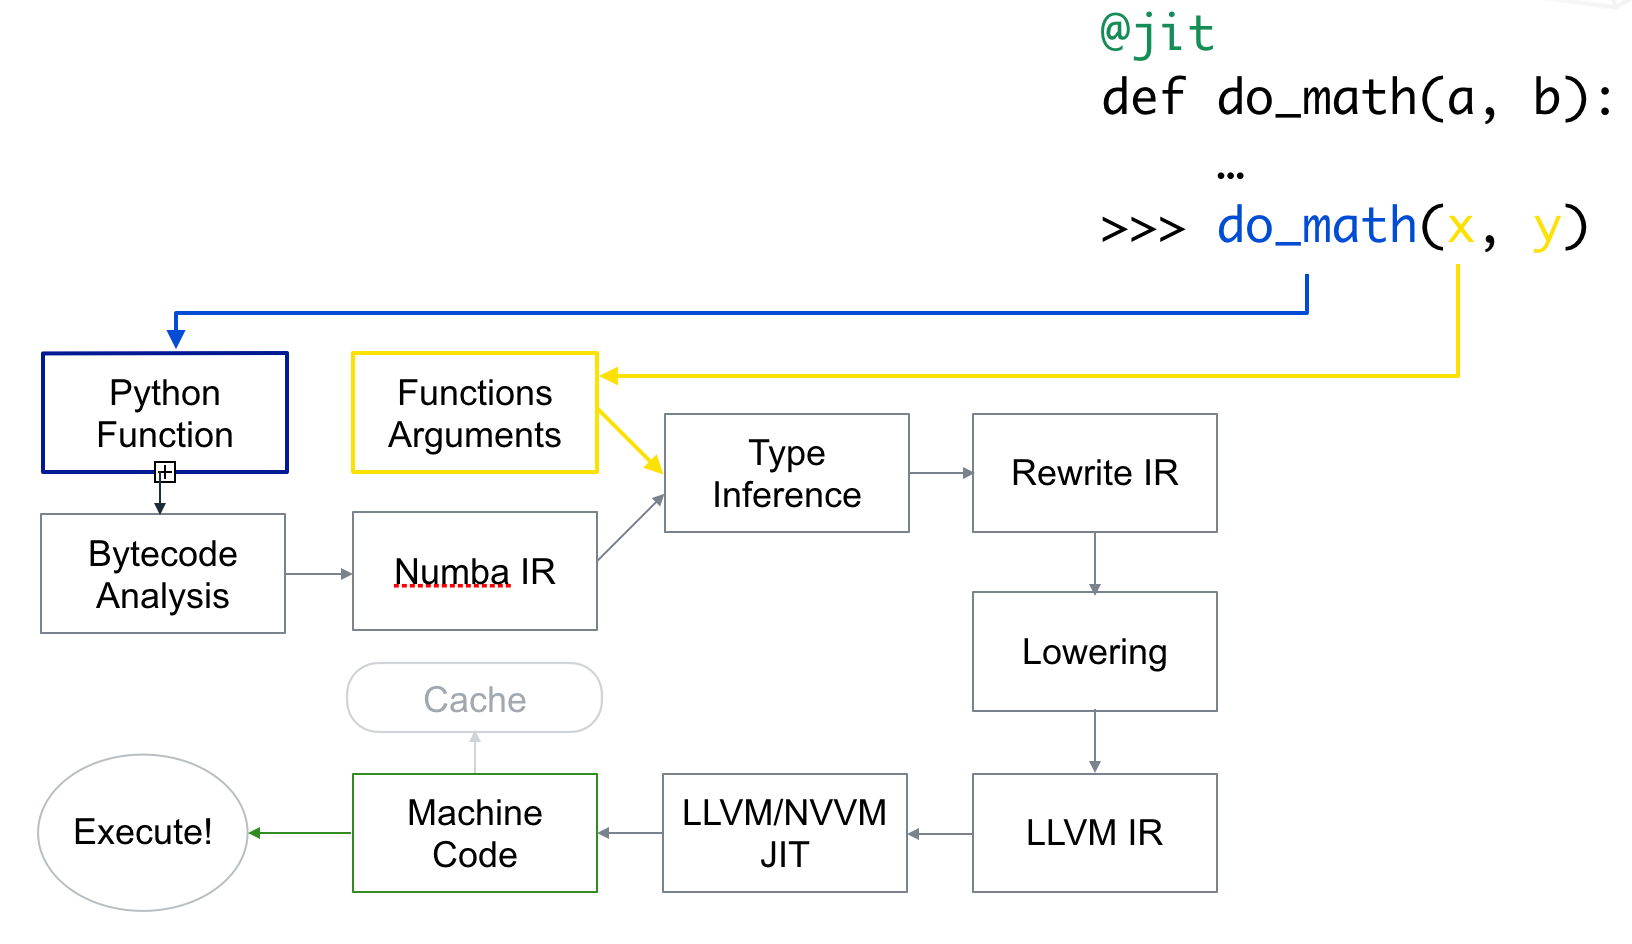

In [30]:
from IPython.display import Image
Image("numba_flowchart.png")

                                            Figure 4

Numba will fall back to a mode, called object mode, which does not do type-specialization. Object mode exists to enable other Numba functionality, but in many cases, you want Numba to tell you if type inference fails. You can force nopython mode (the other compilation mode) by passing the nopython argument to the decorator:

In [9]:
from numba import njit,jit,vectorize,prange
from numba import cuda
import numpy as np
#import struct
import random
import time
import tensorflow as tf

In [4]:
nsamples = 10000000

In [23]:
import random

def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

@jit
def monte_carlo_pi_jit(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

@njit
def monte_carlo_pi_njit(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [24]:
start = time.time()
monte_carlo_pi(nsamples)
end = time.time()
print("time = ",end - start)

time =  3.749324083328247


In [25]:
start = time.time()
monte_carlo_pi_jit(nsamples)
end = time.time()
print("time = ",end - start)

time =  0.13100433349609375


In [27]:
start = time.time()
monte_carlo_pi_njit(nsamples)
end = time.time()
print("time = ",end - start)

time =  0.08489608764648438


### Vectorize:

Numba has the ability to create compiled ufuncs, typically a not-so-straighforward process involving C code. With Numba you simply implement a scalar function to be performed on all the inputs, decorate it with @vectorize, and Numba will figure out the broadcast rules for you.

For such a simple function call, a lot of things just happened! Numba just automatically:

   -Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.<br>
   -Allocated GPU memory for the inputs and the output.<br>
   -Copied the input data to the GPU.<br>
   -Executed the CUDA kernel (GPU function) with the correct kernel dimensions given the input sizes.<br>
   -Copied the result back from the GPU to the CPU.<br>
   -Returned the result as a NumPy array on the host.<br>

Compared to an implementation in C, the above is remarkably more concise.

In [8]:
x = np.random.randint(10, size=784)
y = np.random.randint(10, size=784)

In [9]:
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [12]:
start = time.time()
add_ufunc(x, y)
end = time.time()
print("time = ",end - start)

time =  0.0015187263488769531


In [11]:
start = time.time()
np.add(x,y)
end = time.time()
print("time = ",end - start)

time =  0.0001995563507080078


### Cuda

Ufuncs are really quite fantastic if and when you want to perform element wise operations, which is a very common task. There are any number of functions however, that do not fit this description. To compile functions for the GPU that are not element wise, vectorized functions, we use numba.cuda.jit. In the next section of this course we work extensively with numba.cuda.jit, but for now, let us demonstrate how to use it to decorate a helper function, to be utilized by a GPU accelerated ufunc, so that you are not required to cram all your logic into a single ufunc defintion.

The argument device=True indicates that the decorated function can only be called from a function running on the GPU, and not from CPU host code:

In [14]:
@cuda.jit
def add_kernel(x,y,out):
    idx = cuda.grid(1)
    out[idx] = x[idx] + y[idx]

In [15]:
n = 4096
x = np.arange(n).astype(np.int32) # [0...4095] on the host
y = np.ones_like(x)               # [1...1] on the host

d_x = cuda.to_device(x) # Copy of x on the device
d_y = cuda.to_device(y) # Copy of y on the device
d_out = cuda.device_array_like(d_x) # Like np.array_like, but for device arrays

# Because of how we wrote the kernel above, we need to have a 1 thread to one data element mapping,
# therefore we define the number of threads in the grid (128*32) to equal n (4096).
threads_per_block = 128
blocks_per_grid = 32

In [16]:
start = time.time()
add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)
cuda.synchronize()
end = time.time()
print("time = ",end - start)
print(d_out.copy_to_host()) # Should be [1...4096]

time =  0.07414460182189941
[   1    2    3 ... 4094 4095 4096]


This is a sample program in which list of lists of dictionaries are used just like what we have in our program and convert those dictionaries into arrays so that key and value forms a row in an array. This is then implemented in cuda to increase the speed:

In [2]:
@cuda.jit
def add(d,w):
    x,y = cuda.grid(2) 
    d[x][y] = d[x][y] + 20

In [3]:
my_dict = [[{'00001' : 1, '24324' : 0},{'13' : 1, '24' : 0}],[{'13124' : 1, '24324' : 0},{'13' : 1, '24' : 0}]]
di = []
for j in range(len(my_dict)):
    for i in range(len(my_dict[j])):
        for key, value in my_dict[j][i].items():
            temp = [key,value]
            di.append(temp)
            
di = np.asarray(di).astype(np.int32)
w = [1,2,3]
wi = np.asarray(w).astype(np.int32)

In [4]:
threads_per_block = 16
blocks_per_grid = 1
    
starttest = time.time()
w_d = cuda.to_device(w)
di_d = cuda.to_device(di)
add[blocks_per_grid,threads_per_block](di_d,w_d)
cuda.synchronize()
endtest = time.time()
print("cuda time = ",endtest - starttest)

print(di_d)
print(di_d.copy_to_host()) 

cuda time =  0.3884415626525879
[[   21     1]
 [24344     0]
 [   33     1]
 [   44     0]
 [13144     1]
 [24344     0]
 [   33     1]
 [   44     0]]


Another feature of the code transformation pass (when parallel=True) is support for explicit parallel loops. One can use Numba’s prange instead of range to specify that a loop can be parallelized. The user is required to make sure that the loop does not have cross iteration dependencies except for supported reductions.

We are not able to use JIT inside the class. I found a way to use a Numba-JITed function inside of a class.

The trick is to use a static method, since this kind of methods are not called prepending the object instance to the argument list. The downside of not having access to self is that you cannot use variables defined outside of the method. So you have to pass them to the static method from a calling method that has access to self. In my case I did not need to define a wrapper method. I just had to split the method I wanted to JIT compile into two methods.

In the case of your example, the solution would be:

In [69]:
class MyClass:
    def __init__(self):
        self.k = 1

    def calculation(self):
        k = self.k
        return k

    @staticmethod
    @njit(parallel = True)                           
    def complicated(x,k):                                  
        w = 0
        for i in prange(3):
            w = w
        for a in x:
            b = a**2 + a**3 + k
        return b


if __name__ == "__main__":
    cl = MyClass()
    k = cl.calculation()
    x = [1,2,3]
    start = time.time()
    cl.complicated(x,k)
    end = time.time()
    print("time = ",end - start)

time =  0.09700465202331543


The new code does not use dictionaries. In this program dictionaries are converted into ndarray where in one column their RAM address and the value in that RAM is present. This program is very costly as one more for loop (98 loops) are added in the program.
Our program has 4 for loops and the logical way to increase the speed in these is by applying njit which is made to lift the loops in the program. In our program there are several issues while implementing njit like we cannot use enumerate, for x in list, max, str etc. which makes python easy to use. So everythong is converted like c++ programing and then implemented njit which was then successfully implemented and increased the speed of training module by 67.8 times and the testing module by 84.87 times

WiSARD code:

In [52]:
def preprocessing(tx_train, ty_train, tx_test, ty_test):
        
    py_train = ty_train.flatten()
    py_test = ty_test.flatten()
    
    px_test = tx_test.reshape(10000,input_size)
    px_train = tx_train.reshape(60000,input_size)
    
    px_train = np.asarray(px_train).astype(np.int32)
    py_train = np.asarray(py_train).astype(np.int32)
    px_test = np.asarray(px_test).astype(np.int32)
    py_test = np.asarray(py_test).astype(np.int32)

    return px_train, py_train, px_test, py_test   


In [82]:
class WiSARD:                                                     
    
    def __init__(self,input_size,no_of_rand_pix_selec,nodes,ram_address_count,dis_number):
        self.input_size = input_size
        self.no_of_rand_pix_selec = no_of_rand_pix_selec
        self.nodes = nodes
        self.ram_address_count = ram_address_count
        self.dis_number = dis_number 


    def discriminator(self):
        discriminator = []
        accumulated_pos = []
        my_list = list(range(0,self.input_size))
        for i in range(self.dis_number):  #10
            ram = []
            random.shuffle(my_list)
            for j in range((int)((self.nodes))): #98    
                total_pos = []            
                positions = []
                positions = my_list[j*no_of_rand_pix_selec:j*no_of_rand_pix_selec+no_of_rand_pix_selec]
                accumulated_pos.append(positions)
                total_pos = np.vstack(positions)
                #print(total_pos)
                table = []
                dictionary = {}
                
                max = len("{0:b}".format(2**len(total_pos))) - 1
                for i in range(2**len(total_pos)):
                    x = (('0' * max) + "{0:b}".format(i))
                    x = x[len(x)-max:]
                    dictionary[x] = 0
                table.append(dictionary)
                #print(table)
                ram.append(table)
        
            di = []
            for j in range(len(ram)):
                for i in range(len(ram[j])):
                    for key, value in ram[j][i].items():
                        temp = [key,value]
                        di.append(temp)
                        
            discriminator.append(di)
    
        discriminator = np.asarray(discriminator).astype(np.int32)
        accumulated_pos = np.asarray(accumulated_pos).astype(np.int32)
        return discriminator, accumulated_pos
        
    
    @staticmethod
    @njit(parallel = True)
    def train(d,pos,x_train, y_train):
        
        images = x_train
        lable = y_train    
        
        for i in range(len(images)):
            image = images[i]
            num = lable[i]
            all_ram_of_selected_discriminator = d[num]
            t_ratina = pos[(int)(nodes*num):(int)(nodes*num+nodes)]
            
            for i in range((int)(nodes)):
                part = all_ram_of_selected_discriminator[(ram_address_count*i):(ram_address_count*i+ram_address_count)]
                ratina_for_one_ram = t_ratina[i]
                
                #threshold = 0               
                n = []                                                                
                for ix in prange(len(ratina_for_one_ram)):
                    pix = ratina_for_one_ram[ix]
                    if image[(pix-1)]>=1:
                        n.append(1)
                        #threshold = threshold + 1     
                    else:
                        n.append(0)
                
                num = 0
                for i in range(no_of_rand_pix_selec):
                    num = (n[i])*(10**((no_of_rand_pix_selec-1)-i)) + num
            
                address_of_that_ram = (int)(num)
                for key in prange(ram_address_count):
                    index = part[key]
                    #if threshold >= 1:          
                    if index[0] == address_of_that_ram:
                        index[1] = 1                        
                        
    
    @staticmethod
    @njit(parallel = True)
    def train_with_bleeching(d,pos,x_train, y_train):
        
        images = x_train
        lable = y_train    
        
        for i in range(len(images)):
            image = images[i]
            num = lable[i]
            all_ram_of_selected_discriminator = d[num]
            t_ratina = pos[(int)(nodes*num):(int)(nodes*num+nodes)]
            
            for i in range((int)(nodes)):
                part = all_ram_of_selected_discriminator[(ram_address_count*i):(ram_address_count*i+ram_address_count)]
                ratina_for_one_ram = t_ratina[i]
                
                #threshold = 0               
                n = []                                                                
                for ix in prange(len(ratina_for_one_ram)):
                    pix = ratina_for_one_ram[ix]
                    if image[(pix-1)]>=1:
                        n.append(1)
                        #threshold = threshold + 1     
                    else:
                        n.append(0)
                
                num = 0
                for i in range(no_of_rand_pix_selec):
                    num = (n[i])*(10**((no_of_rand_pix_selec-1)-i)) + num
            
                address_of_that_ram = (int)(num)
                for key in prange(ram_address_count):
                    index = part[key]
                    #if threshold >= 1:          
                    if index[0] == address_of_that_ram:
                        index[1] += 1
            


    @staticmethod
    @njit(parallel = True)
    def test(d,pos,x_test,y_test):
        right = 0
        wrong = 0
        images = x_test
        lable = y_test
        
        for i in range(len(images)):
            image = images[i]
            actual_lable = lable[i]
            
            total_sum=[]
            
            for ix in prange(dis_number):
                
                t_ratina = pos[int((nodes*ix)):(int)((nodes*ix+nodes))]
                
                sum_of_ram_output = 0
                dis = d[ix]
                
                for i in range(int(nodes)):
                    part = dis[(ram_address_count*i):(ram_address_count*i+ram_address_count)]
                    ratina_for_one_ram = t_ratina[i]
                    
                    n = []                                                                
                    for pix in ratina_for_one_ram:
                        if image[(pix-1)]>=1:
                            n.append(1)
                        else:
                            n.append(0)
                    
                    num = 0
                    for i in range(no_of_rand_pix_selec):
                        num = (n[i])*(10**((no_of_rand_pix_selec-1)-i)) + num
                    
                    address_of_that_ram = (int)(num)
                
                    for key in range(len(part)):
                        prt = part[key]
                        if prt[0] == address_of_that_ram and prt[1]>=1:
                            sum_of_ram_output += 1
                
                total_sum.append(sum_of_ram_output)        
        
            max_sum = 0
            idx = 0
            for i in prange(len(total_sum)):
                if max_sum < total_sum[i]:
                    max_sum = total_sum[i]
                    idx = i
            index_of_dis = idx
            if index_of_dis == actual_lable:
                right += 1
            else:
                wrong += 1
                
        return right,wrong




    #@vectorize(['int32(int32,int32,int32,int32)'], target = 'cuda')
    @staticmethod
    @njit(parallel = True)
    def test_with_bleaching(d,pos,x_test,y_test):
        right = 0
        wrong = 0
        images = x_test
        lable = y_test
        ct = 0.02
        b=1
        
        for i in range(len(images)):
            image = images[i]
            actual_lable = lable[i]
            
            total_sum=[]
            
            for ix in prange(dis_number):
                
                t_ratina = pos[int((nodes*ix)):(int)((nodes*ix+nodes))]
                
                sum_of_ram_output = 0
                dis = d[ix]
                
                for i in range(int(nodes)):
                    part = dis[(ram_address_count*i):(ram_address_count*i+ram_address_count)]
                    ratina_for_one_ram = t_ratina[i]
                    
                    n = []                                                                
                    for pix in ratina_for_one_ram:
                        if image[(pix-1)]>=1:
                            n.append(1)
                        else:
                            n.append(0)
                    
                    num = 0
                    for i in range(no_of_rand_pix_selec):
                        num = (n[i])*(10**((no_of_rand_pix_selec-1)-i)) + num
                    
                    address_of_that_ram = (int)(num)
                
                    for key in range(len(part)):
                        prt = part[key]
                        if prt[0] == address_of_that_ram and prt[1]>=b:           
                            sum_of_ram_output += 1
                
                total_sum.append(sum_of_ram_output)        
        
            max_sum = 0
            sec_max = 0
            idx = 0
            
            for i in prange(len(total_sum)):
                if max_sum < total_sum[i]:
                    max_sum = total_sum[i]
                    idx = i
                    
            for j in prange(len(total_sum)):
                if sec_max < total_sum[j] and j!=idx:
                    sec_max = total_sum[j]
                    
            index_of_dis = idx
            if index_of_dis == actual_lable:
                right += 1
            else:
                wrong += 1
            
            if max_sum == sec_max:
                confidence = 0
            else:
                confidence = 1 - float(sec_max)/float(max_sum)
                if confidence < ct:
                    b += 1
        
        return right,wrong

In [83]:
input_size = 28*28
no_of_rand_pix_selec = 2**(3)     ## ** (must) no_of_rand_pix_selec = 2^(n) where n is 0,1,2...
nodes = int(input_size/no_of_rand_pix_selec)    #98
ram_address_count = 2**(no_of_rand_pix_selec)   #256
dis_number = 10                #10 i.e number of lables

In [84]:
(tx_train, ty_train), (tx_test, ty_test) = tf.keras.datasets.mnist.load_data()
px_train, py_train, px_test, py_test = preprocessing(tx_train, ty_train, tx_test, ty_test)

In [85]:
w = WiSARD(input_size,no_of_rand_pix_selec,nodes,ram_address_count,dis_number)

In [86]:
d, acc_pos = w.discriminator()

In [87]:
starttrain = time.time()
w.train_with_bleeching(d,acc_pos,px_train[0:60000],py_train[0:60000])
endtrain = time.time()
print("time train = ",endtrain - starttrain)

time train =  18.927642345428467


In [68]:
starttest = time.time()
right,wrong = w.test_with_bleaching(d,acc_pos,px_test[0:10000],py_test[0:10000])
endtest = time.time()
print("time test = ",endtest - starttest)

time test =  30.981372594833374


In [125]:
print("number of right result = ",right)
print("number of wrong results = ",wrong)
accuracy = ((right)/(right+wrong))*100
print("accuracy by testing the model =",accuracy)

number of right result =  8691
number of wrong results =  1309
accuracy by testing the model = 86.91


### Analysis:

The training time of 60,000 images was 1288.741 seconds, the testing time was 2654.127 seconds. Now once we implemented numba the training time was 19.007 seconds; the testing time was 31.272 seconds. This is still 6.72 times faster to train then the initial code with dictionaries and 8.27 times faster to test

The time comarison to train the network with and with numba implementation is given below:

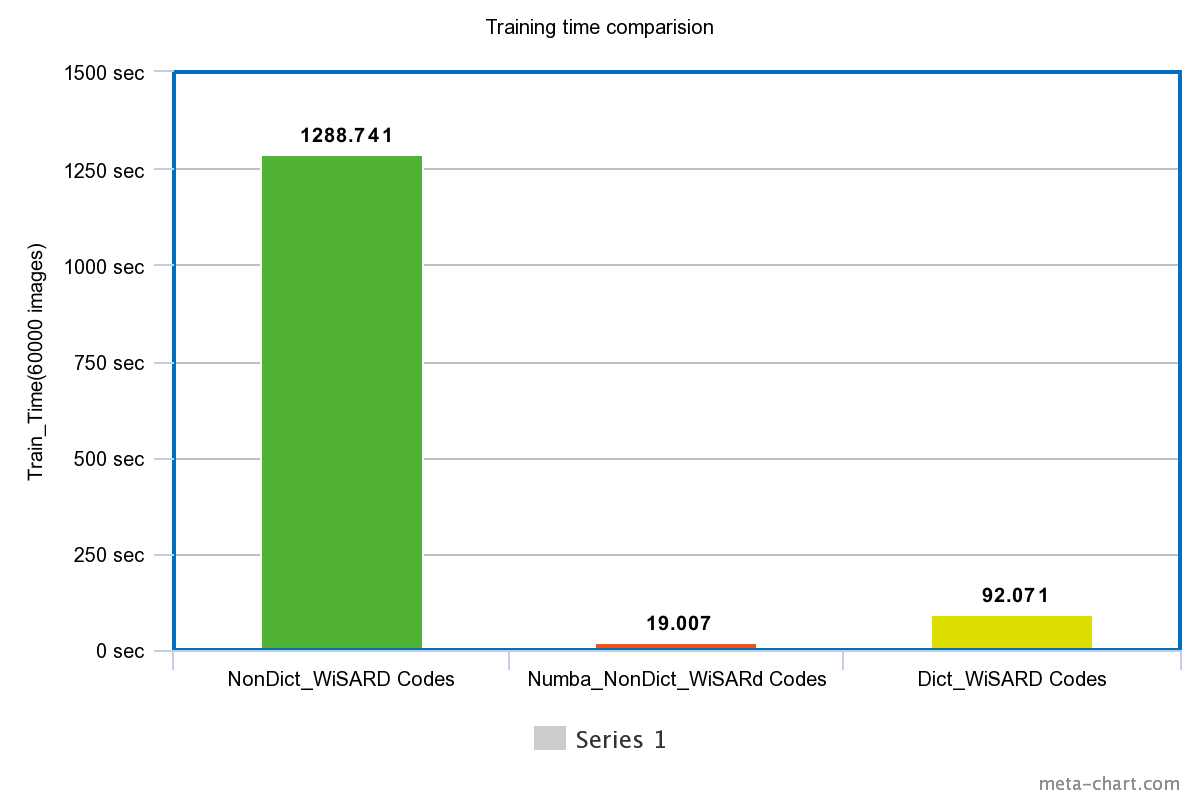

In [42]:
from IPython.display import Image
Image("pre_Train_time_comparision.png")

                                                       figure 5

The time comarison to test the network with and with numba implementation is given below:

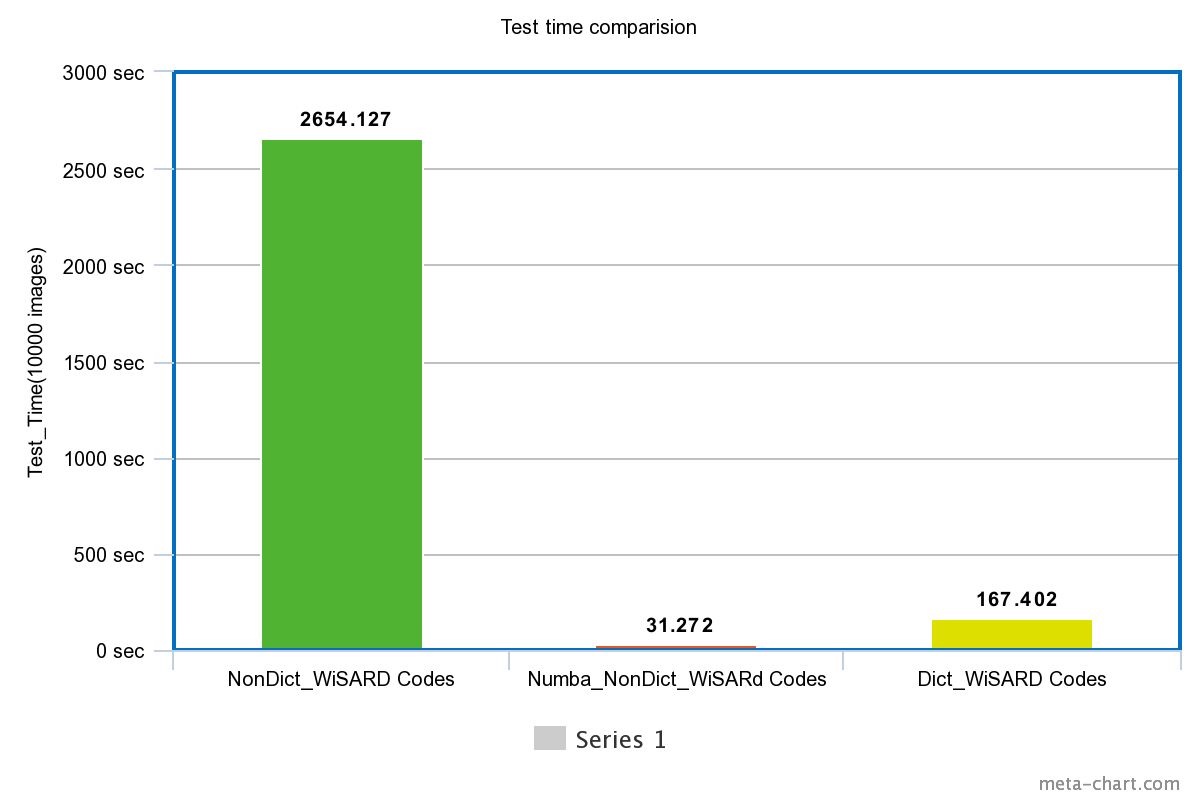

In [43]:
from IPython.display import Image
Image("pre_Test_time_comparision_2.png")

                                                      Figure 6

The training time of c++ open source(https://github.com/giordamaug/WisardLibrary) by 60000 images is 283.39 seconds and the testing time of 10000 images is 642.11 seconds. Our numba implemented code is 14.91 times faster in training the network and 20.7 times faster in testing.

The time comparison (test and train) of my code and open source c++ code (https://github.com/giordamaug/WisardLibrary) with full MNIST dataset is given below

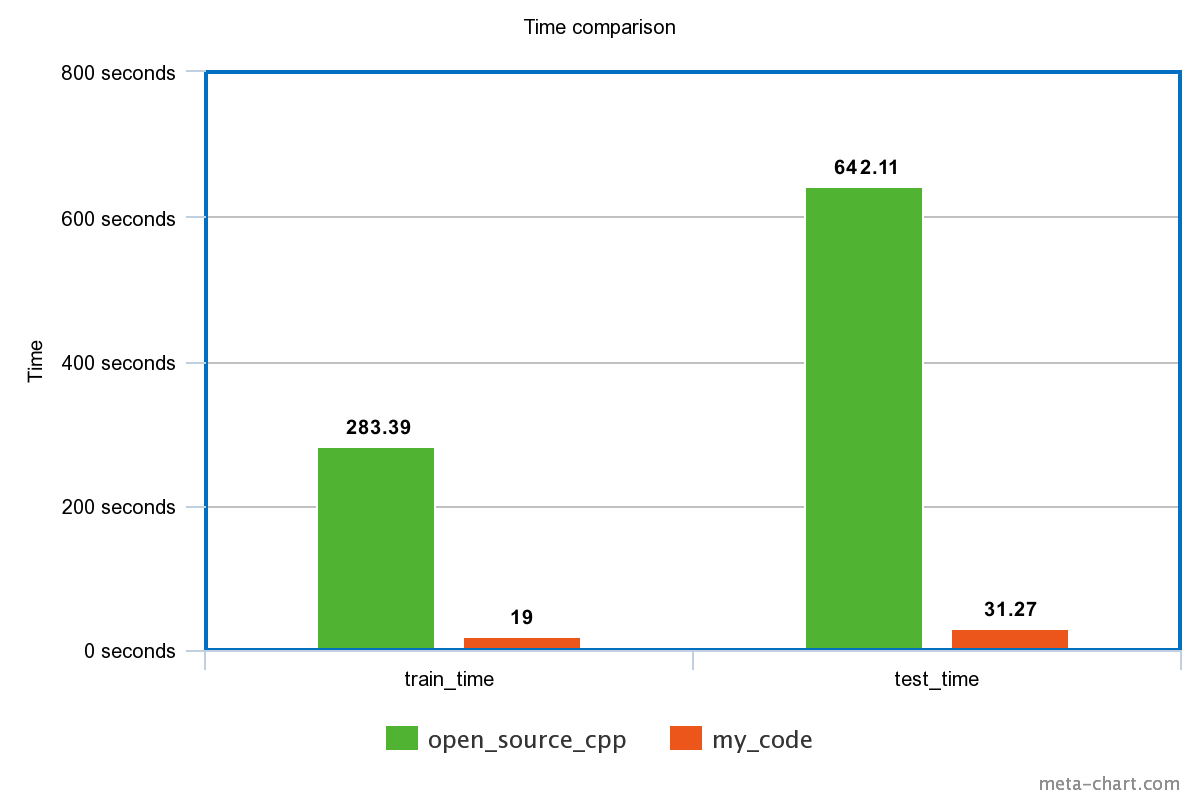

In [44]:
from IPython.display import Image
Image("pre_time_com.png")

                                                        FIGURE 7

I included bleaching technique to overcome the saturation problem I get with big dataset. There are different functions for bleaching and non-bleaching technique so that user can use any one of them when needed.After I implemented bleaching technique the accuracy with full MNIST dataset is 87 percentage with retina length 8.

The accuracy comparison of my code and open source c++ code (https://github.com/giordamaug/WisardLibrary) with full MNIST dataset is given below:

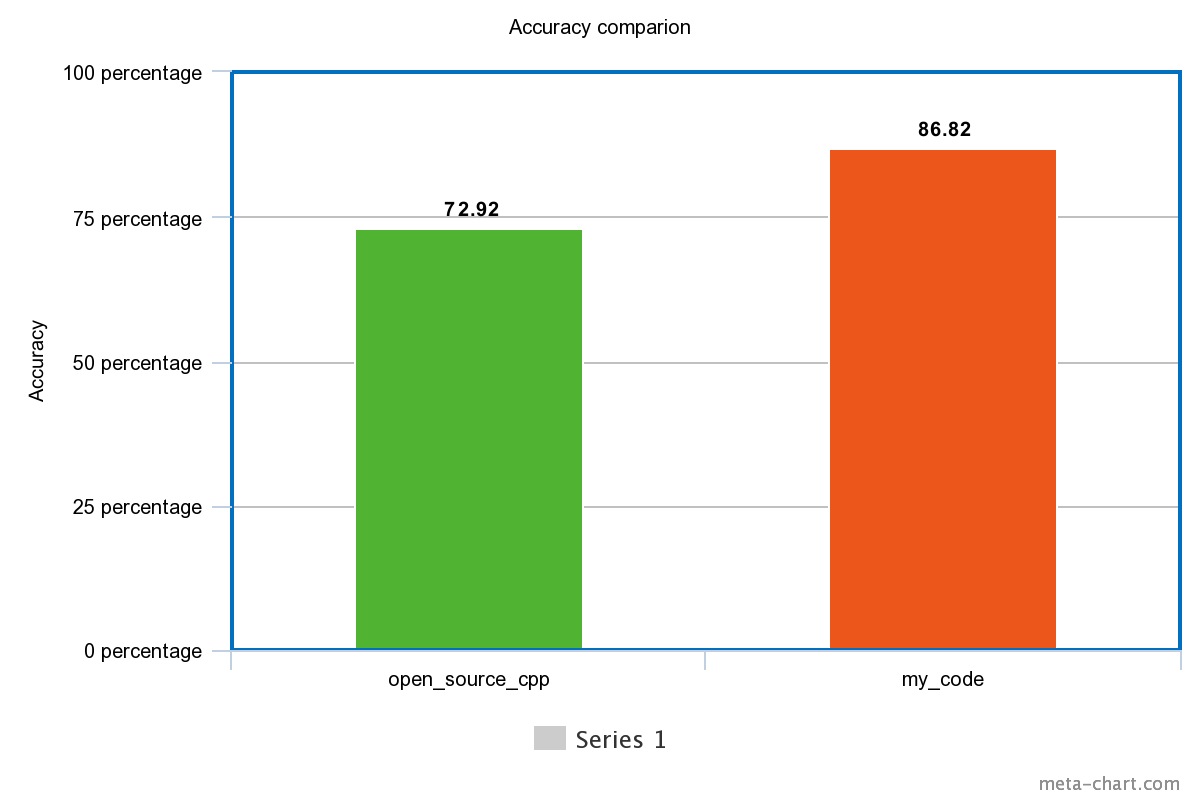

In [46]:
from IPython.display import Image
Image("pre_acc_comp.png")

                                                          Figure 8

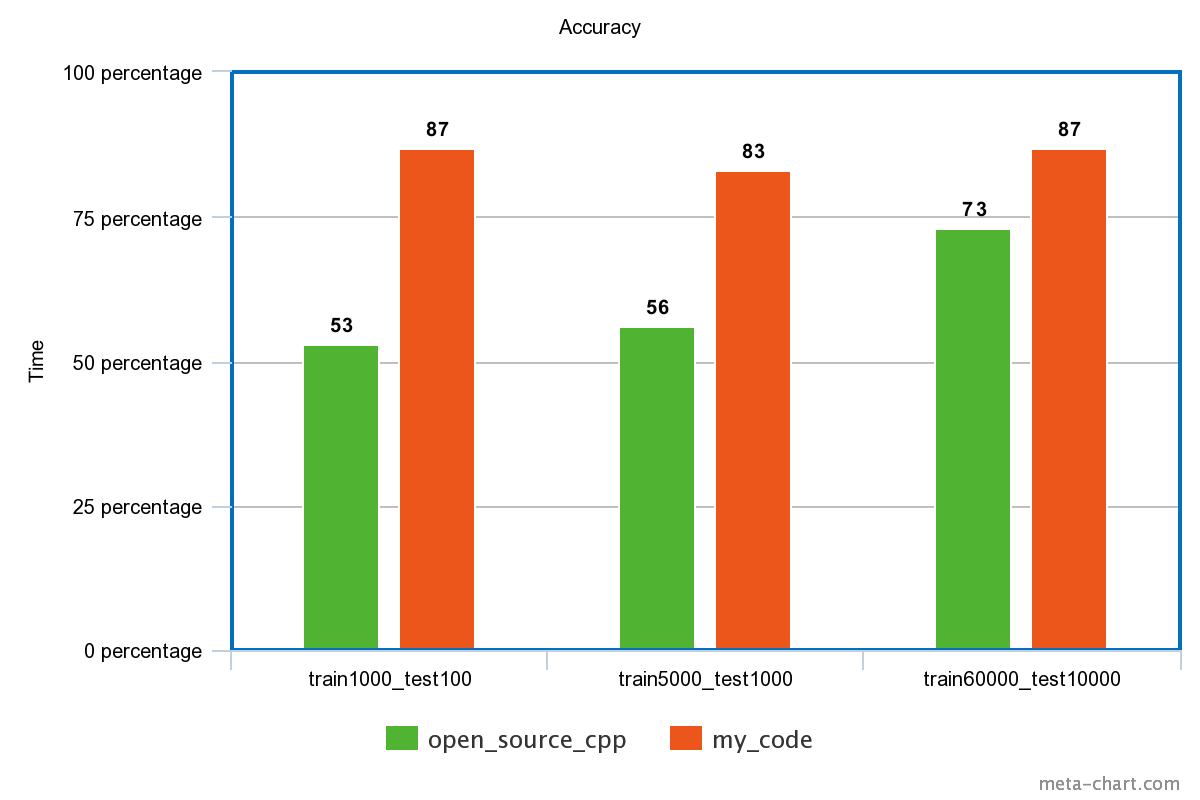

In [45]:
from IPython.display import Image
Image("pre_acc_com.png")

                                                             Figure 9